In [1]:
from transformers import ViTModel

/home/nirmal/miniconda3/envs/Transformers/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

In [3]:
vit_model

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

In [4]:
from transformers import AutoFeatureExtractor
feature_extractor = AutoFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

/home/nirmal/miniconda3/envs/Transformers/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [5]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [6]:
from PIL import Image

In [7]:
img = Image.open('combined_dataset_256x/rus_0.png')

In [8]:
feature_extractor(img)

{'pixel_values': [array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]],
      shape=(3, 224, 224), dtype=float32)]}

In [9]:
reduced_size_img = feature_extractor(img)

In [10]:
reduced_size_img.pixel_values[0].shape

(3, 224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


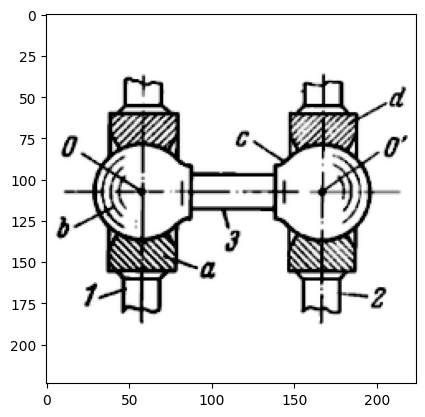

In [11]:
import matplotlib.pyplot as plt
plt.imshow(reduced_size_img.pixel_values[0].transpose(1,2,0))

## Fine Tuning an image captioning system

In [12]:
import torch
from torch import device

# Set device to GPU if available, otherwise use CPU
device = device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


In [13]:
from transformers import VisionEncoderDecoderModel, GPT2TokenizerFast,AutoFeatureExtractor,AutoTokenizer, TrainingArguments, Trainer
from sklearn.feature_extraction.text import CountVectorizer
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
#from datasets import Dataset
import torch
import numpy as np
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, Resize
import pandas as pd
import requests
from io import BytesIO


In [14]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained('google/vit-base-patch16-224-in21k',
                                                                  'distilgpt2')

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.2.crossattention.c_attn.bias', 'transformer.h.2.crossattention.c_attn.weight', 'transformer.h.2.crossattention.c_proj.bias', 'transformer.h.2.cr

In [15]:
type(model.encoder)

transformers.models.vit.modeling_vit.ViTModel

In [16]:
model.encoder

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

In [17]:
model.decoder

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (crossattention): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=1536, nx=768)
          (q_attn): Conv1D(nf=768, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_cross_attn): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_

In [18]:
model

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(i

In [19]:
total_params = 0
for param in model.parameters():
    total_params += torch.numel(param)

print(f"Our model has a combined {total_params:,} parameters")

Our model has a combined 182,485,248 parameters


In [20]:
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained('distilgpt2')

In [21]:
IMAGES_PATH = f"combined_dataset_256x/"

In [22]:
import os
import json
# MIN_CAPTION = 5  # Minimum caption length
# MAX_CAPTION = 511  # Maximum caption length

def load_captions_data_jsonl(filename):
    caption_mapping = {}
    text_data = []

    with open(filename) as caption_file:
        for line in caption_file:
            data = json.loads(line)
            img_name = data["file_name"]
            caption = data["text"]

            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            if img_name.endswith((".jpg",".png")):
                caption = caption.replace(' .', '').strip()
                tokens = caption.split()
                # if len(tokens) < MIN_CAPTION:
                #     continue
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

    return caption_mapping, text_data

# Load the dataset
captions_mapping, text_data = load_captions_data_jsonl(f"combined_dataset_256x/metadata.jsonl")


In [23]:
len(captions_mapping)

8993

In [24]:
list(captions_mapping.items())[:5]

[('combined_dataset_256x/y_0.jpg',
  ['3D sketch. Chain drive. Chain coupling.']),
 ('combined_dataset_256x/y_1.jpg',
  ['3D sketch. Coil spring coupling. Due to revolution joints of the spring supports (in pink) this coupling can compensate a large offset of the shaft axes. Offset = 1 mm. Velocity variation is considerable.']),
 ('combined_dataset_256x/y_10.jpg',
  ['3D sketch. Application of parallelogram mechanism. Transmission of rotation movement between parallel shafts. The red disk rotates without fixed bearing.']),
 ('combined_dataset_256x/y_100.jpg',
  ['3D sketch. One way clutch 3 (jaw). The orange input shaft rotates two directions but the transmission is possible for one direction only. There is collision when the output green shaft stops, so the mechanism should be used only for low speed.']),
 ('combined_dataset_256x/y_1000.jpg',
  ['3D sketch. Spatial double crank slider mechanism. It is an application of Hobson’s joint for air compressors. Input: orange shaft. Center of

In [25]:
feature_extractor.size

{'height': 224, 'width': 224}

In [26]:
normalize = Normalize(
    mean=feature_extractor.image_mean,
    std=feature_extractor.image_std
)

_transforms = Compose(
    [
        RandomResizedCrop(size=(224,224)),   # Data augmentation. Take a random resized crop of our image
        ToTensor(),                                  # Convert to pytorch tensor
        normalize                                    # normalize pixel values to look like images during pre-training
    ]
)

In [27]:
from datasets import Dataset
rows = []

# I'm ok using multiple captions per image becuase of our data augmentation
for path, captions in captions_mapping.items():
    for caption in captions:
        rows.append({'path': path, 'caption': caption})

image_df = pd.DataFrame(rows)

image_dataset = Dataset.from_pandas(image_df)

In [28]:
image_df.shape

(8993, 2)

In [29]:
image_df.head()

,path,caption
0,combined_dataset_256x/y_0.jpg,3D sketch. Chain drive. Chain coupling.
1,combined_dataset_256x/y_1.jpg,3D sketch. Coil spring coupling. Due to revolu...
2,combined_dataset_256x/y_10.jpg,3D sketch. Application of parallelogram mechan...
3,combined_dataset_256x/y_100.jpg,3D sketch. One way clutch 3 (jaw). The orange ...
4,combined_dataset_256x/y_1000.jpg,3D sketch. Spatial double crank slider mechani...


In [30]:
image_df.tail()

,path,caption
8988,combined_dataset_256x/rus_995.png,2d schematics. LONG-STROKE RAPID-RETURN SPATIA...
8989,combined_dataset_256x/rus_996.png,2d schematics. CAM-LEVER MECHANISM WITH A LARG...
8990,combined_dataset_256x/rus_997.png,2d schematics. PLATFORM HOISTING MECHANISM. Sh...
8991,combined_dataset_256x/rus_998.png,2d schematics. CAM-LEVER CHAIN DRIVE MECHANISM...
8992,combined_dataset_256x/rus_999.png,2d schematics. CAM-LEVER MECHANISM FOR MOTION ...


In [31]:
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

def image_preprocess(examples):
    # ViT expects pixel_values instead of input_ids
    examples['pixel_values'] = [_transforms(Image.open(path)) for path in examples['path']]
    # We are padding tokens here instead of using a datacollator
    tokenized = gpt2_tokenizer(
        examples['caption'], padding='max_length', max_length=10, truncation=True
    )['input_ids']
    # the output captions
    examples['labels'] = [[l if l != gpt2_tokenizer.pad_token_id else -100 for l in t] for t in tokenized]

    # delete unused keys
    del examples['path']
    del examples['caption']
    return examples

In [32]:
image_dataset = image_dataset.map(image_preprocess, batched=True)

Map:   0%|          | 0/8993 [00:00<?, ? examples/s]

Map: 100%|██████████| 8993/8993 [01:09<00:00, 128.48 examples/s]


Map:  78%|███████▊  | 7000/8993 [01:01<00:14, 135.41 examples/s]

In [33]:
image_dataset = image_dataset.train_test_split(test_size=0.1)

In [34]:
image_dataset

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 8093
    })
    test: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 900
    })
})

In [35]:
# We set a pad token and a start token in our combined model to be the same as gpt2

model.config.pad_token = gpt2_tokenizer.pad_token
model.config.pad_token_id = gpt2_tokenizer.pad_token_id

model.config.decoder_start_token = gpt2_tokenizer.bos_token
model.config.decoder_start_token_id = gpt2_tokenizer.bos_token_id

In [36]:
# freeze all but the last two layers in the ViT
for name, param in model.encoder.named_parameters():
    if 'encoder.layer.10' in name:
        break
    param.requires_grad = False

In [37]:
training_args = TrainingArguments(
    output_dir='./mech_image_captioning', # The output directory
    overwrite_output_dir=True, # overwrite the content of the output directory
    num_train_epochs=4, # number of training epochs
    per_device_train_batch_size=64, # batch size for training
    per_device_eval_batch_size=64,  # batch size for evaluation
    load_best_model_at_end=True,
    log_level='info',
    logging_steps=50,
    evaluation_strategy='epoch',
    save_strategy='epoch',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=image_dataset['train'],
    eval_dataset=image_dataset['test'],
)

/home/nirmal/miniconda3/envs/Transformers/lib/python3.12/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [38]:
trainer.evaluate()


***** Running Evaluation *****
  Num examples = 900
  Batch size = 64


{'eval_loss': 5.994901180267334,
 'eval_model_preparation_time': 0.0045,
 'eval_runtime': 99.0182,
 'eval_samples_per_second': 9.089,
 'eval_steps_per_second': 0.151}

In [39]:
trainer.train()

***** Running training *****
  Num examples = 8,093
  Num Epochs = 4
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 508
  Number of trainable parameters = 110,863,872


Epoch,Training Loss,Validation Loss,Model Preparation Time
1,1.780100,1.526981,0.004500
2,1.423300,1.361455,0.004500
3,1.284000,1.287669,0.004500
4,1.206800,1.269448,0.004500



***** Running Evaluation *****
  Num examples = 900
  Batch size = 64
Saving model checkpoint to ./mech_image_captioning/checkpoint-127
Configuration saved in ./mech_image_captioning/checkpoint-127/config.json
Configuration saved in ./mech_image_captioning/checkpoint-127/generation_config.json
Model weights saved in ./mech_image_captioning/checkpoint-127/model.safetensors

***** Running Evaluation *****
  Num examples = 900
  Batch size = 64
Saving model checkpoint to ./mech_image_captioning/checkpoint-254
Configuration saved in ./mech_image_captioning/checkpoint-254/config.json
Configuration saved in ./mech_image_captioning/checkpoint-254/generation_config.json
Model weights saved in ./mech_image_captioning/checkpoint-254/model.safetensors

***** Running Evaluation *****
  Num examples = 900
  Batch size = 64
Saving model checkpoint to ./mech_image_captioning/checkpoint-381
Configuration saved in ./mech_image_captioning/checkpoint-381/config.json
Configuration saved in ./mech_image_c

TrainOutput(global_step=508, training_loss=1.5140776596670076, metrics={'train_runtime': 3711.98, 'train_samples_per_second': 8.721, 'train_steps_per_second': 0.137, 'total_flos': 4.183907530168074e+18, 'train_loss': 1.5140776596670076, 'epoch': 4.0})

In [40]:
trainer.save_model()

Saving model checkpoint to ./mech_image_captioning
Configuration saved in ./mech_image_captioning/config.json
Configuration saved in ./mech_image_captioning/generation_config.json
Model weights saved in ./mech_image_captioning/model.safetensors


In [41]:
finetuned_model = VisionEncoderDecoderModel.from_pretrained('./mech_image_captioning')

loading configuration file ./mech_image_captioning/config.json
Model config VisionEncoderDecoderConfig {
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "distilgpt2",
    "_num_labels": 1,
    "activation_function": "gelu_new",
    "add_cross_attention": true,
    "architectures": [
      "GPT2LMHeadModel"
    ],
    "attn_pdrop": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 50256,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "embd_pdrop": 0.1,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 50256,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "id2label": {
      "0": "LABEL_0"
    },
    "initializer_range": 0.02,
    "is_decoder": true,
  

In [42]:
# Create a new composition that doesn't crop images for inference to make it easier for the model
inference_transforms = Compose(
    [
        Resize(size=(224,224)),
        ToTensor(),
        normalize
    ]
)

In [43]:
# a helper function to caption images from the web or a file path
def caption_image(m, path):
    if 'http' in path:
        response = requests.get(path)
        img = Image.open(BytesIO(response.content))
        image_matrix = inference_transforms(img).unsqueeze(0)
    else:
        img = Image.open(path)
        image_matrix = inference_transforms(img).unsqueeze(0)

    generated = m.generate(
        image_matrix,
        num_beams=3,
        max_length=15,
        early_stopping=True,
        do_sample=True,
        top_k=10,
        num_return_sequences=5,
    )

    caption_options = [gpt2_tokenizer.decode(g, skip_special_tokens=True).strip() for g in generated]
    display(img)
    return caption_options, generated, image_matrix


In [44]:
captions, generated, image_matrix = caption_image(  # Out of sample photo
    finetuned_model, 'combined_dataset_256x/rus_9.png'
)

captions

ValueError: `num_return_sequences` (5) has to be smaller or equal to `num_beams` (3).

In [46]:
captions, generated, image_matrix = caption_image(  # Another one
    finetuned_model, 'Picture1.jpg'
)

captions

TypeError: 'dict' object cannot be interpreted as an integer

In [ ]:
vec = CountVectorizer(stop_words='english')

bag_of_words = vec.fit_transform(image_df['caption'])

sum_words = bag_of_words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

sorted(words_freq, key = lambda x: x[1], reverse=True)[:20]

In [ ]:
captions, generated, image_matrix = caption_image(  # from our flicker dataset
    finetuned_model,
    ''
)
captions

In [ ]:
non_finetuned = VisionEncoderDecoderModel.from_encoder_decoder_pretrained('google/vit-base-patch16-224-in21k', 'distilgpt2')

In [ ]:
# Sanity check that a pretrained model alone couldn't do this

captions, generated, image_matrix = caption_image(
    non_finetuned, '../data/flicker_images/3148647065_2d6cd88cf6.jpg'
)
captions